# Project main drivers

### For this project three main questions must be answered:

* Where are located the markets in New York?

* What is the best neighborhood and/or borough in that a market will have better chances to thrive?

* What is the most strategic position for a delivery-focused market in relation to proximity to residential Neighborhoods?

## 1. Importing libraries

* Let´s start importing all required Python libraries for this project

In [1]:
import pandas as pd
import numpy as np
import geocoder
import bs4
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

print("No errors found - Everything successfully loaded!")

No errors found - Everything successfully loaded!


## 2 - Scrapping neighborhood data from website (json file)

* The website returns a json file, which means a parsing with BeautifulSoup is not necessary, we can read it directly with the JSON package previously imported.



In [2]:
def new_york_address():
    resp=requests.get('https://cocl.us/new_york_dataset').json()
    features=resp['features']
    # defining the dataframe
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # filling the dataframe with spatial data from the json file
    new_york_address = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_address = new_york_address.append({'Borough': borough,'Neighborhood': neighborhood_name, 'Latitude': neighborhood_lat,'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_address

In [3]:
ny_data = new_york_address()
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(ny_data['Borough'].unique()),
        ny_data.shape[0]
    )
)


The dataframe has 5 boroughs and 306 neighborhoods.


In [4]:
ny_data.head() #checking the newly created dataframe

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## 3 - Putting on Foursquare credentials and fetching data through the API


In [5]:
CLIENT_ID = '0IR3SA2HSAXN2N2UHVALDTJK34ATHB3WJ3UHPJVOU1YTQOBJ'
# Foursquare Client ID
CLIENT_SECRET = 'KP2HTVCZRYDYB2XWILJ1U4SADJE2ZUZ4Y2GIJHUT4RTKUX0O' # Foursquare Client Secret
VERSION = '20180605'
LIMIT = 100

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: 0IR3SA2HSAXN2N2UHVALDTJK34ATHB3WJ3UHPJVOU1YTQOBJ
CLIENT_SECRET:KP2HTVCZRYDYB2XWILJ1U4SADJE2ZUZ4Y2GIJHUT4RTKUX0O


#### 3.1 - Fetching venue coordinates and id through Foursquare API calls

In [6]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [7]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [15]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(ny_data['Latitude'], ny_data['Longitude'], ny_data['Borough'], ny_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [14]:
def get_venues(lat,lng):
    radius=500
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

In [10]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [11]:
ny_data.shape

(306, 4)

## 4 Analyzing collected data 

* Now let's analyse how many markets and supermarkets exists in each neighborhood/ borough.

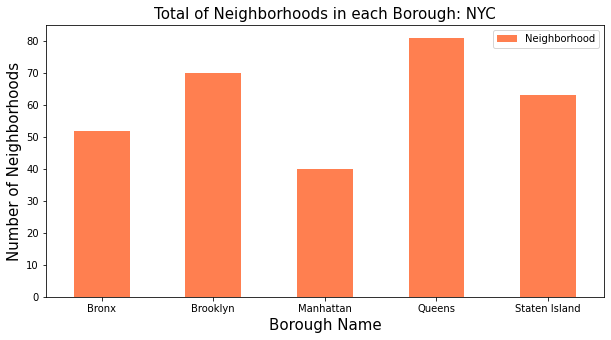

In [12]:
clr = "coral"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Total of Neighborhoods in each Borough: NYC', fontsize = 15)
plt.xlabel('Borough Name', fontsize = 15)
plt.ylabel('Number of Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [121]:
# prepare neighborhood list that contains supermarkets
column_names=['Borough', 'Neighborhood', 'ID','Name']
spmarket_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    spmarket=venues[venues['Category']=='Supermarket']   
    print('(',count,'/',len(ny_data),')','Supermarket in '+Neighborhood+', '+Borough+':'+str(len(spmarket)))
    print(row)
    for resturant_detail in spmarket.values.tolist():
        id, name , category=resturant_detail
        spmarket_ny = spmarket_ny.append({'Borough': Borough,'Neighborhood': Neighborhood, 'ID': id,'Name' : name},ignore_index=True)
    count+=1

73.86704147658772]
( 143 / 306 ) Supermarket in Maspeth, Queens:0
['Queens', 'Maspeth', 40.725427374093606, -73.89621713626859]
( 144 / 306 ) Supermarket in Ridgewood, Queens:0
['Queens', 'Ridgewood', 40.70832315613858, -73.90143517559589]
( 145 / 306 ) Supermarket in Glendale, Queens:0
['Queens', 'Glendale', 40.70276242967838, -73.87074167435605]
( 146 / 306 ) Supermarket in Rego Park, Queens:0
['Queens', 'Rego Park', 40.72897409480735, -73.8578268690537]
( 147 / 306 ) Supermarket in Woodhaven, Queens:0
['Queens', 'Woodhaven', 40.68988687915789, -73.8581104655432]
( 148 / 306 ) Supermarket in Ozone Park, Queens:1
['Queens', 'Ozone Park', 40.680708468265415, -73.84320266173447]
( 149 / 306 ) Supermarket in South Ozone Park, Queens:1
['Queens', 'South Ozone Park', 40.66854957767195, -73.80986478649041]
( 150 / 306 ) Supermarket in College Point, Queens:0
['Queens', 'College Point', 40.784902749260205, -73.84304528896125]
( 151 / 306 ) Supermarket in Whitestone, Queens:1
['Queens', 'Whit

In [122]:
spmarket_ny.to_csv('spmarket_ny.csv')

In [56]:
spmarket_ny = pd.read_csv('spmarket_ny.csv')
spmarket_ny.head()

,Unnamed: 0,Unnamed: 0.1,Borough,Neighborhood,ID,Name
0,0,0,Bronx,Norwood,564f83d4498ee9597ad80f23,Stop & Shop
1,1,1,Bronx,Pelham Parkway,564f83d4498ee9597ad80f23,Stop & Shop
2,2,2,Bronx,City Island,564f83d4498ee9597ad80f23,Stop & Shop
3,3,3,Bronx,Morris Heights,49f85cbbf964a520f26c1fe3,Mitsuwa Marketplace
4,4,4,Bronx,High Bridge,49f85cbbf964a520f26c1fe3,Mitsuwa Marketplace


In [57]:
spmarket_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    78 non-null     int64 
 1   Unnamed: 0.1  78 non-null     int64 
 2   Borough       78 non-null     object
 3   Neighborhood  78 non-null     object
 4   ID            78 non-null     object
 5   Name          78 non-null     object
dtypes: int64(2), object(4)
memory usage: 3.8+ KB


### The call returned 78 different supermarkets in New York. The collected data was saved in a .csv file.
### Now to continue the analysis, let's segment this search querry by Neighborhood, in order to retrieve which Neighborhood has the biggest number of supermarkets

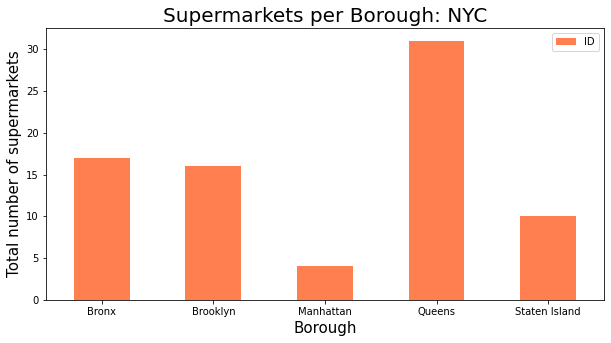

In [76]:
spmarket_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Supermarkets per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Total number of supermarkets', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

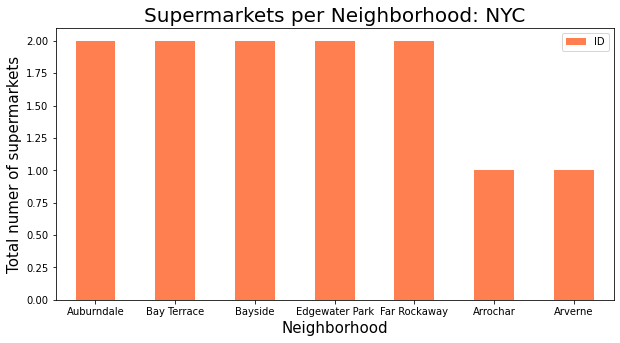

In [58]:
spmarket_ny.groupby('Neighborhood')['ID'].count().nlargest(7).plot.bar(figsize=(10,5), color=clr)
plt.title('Supermarkets per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Total number of supermarkets', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [245]:
spmarket_ny[spmarket_ny['Neighborhood']=='Auburndale']

,Unnamed: 0,Unnamed: 0.1,Borough,Neighborhood,ID,Name
38,38,38,Queens,Auburndale,563c11e8cd1059cb26ede621,Stop & Shop
39,39,39,Queens,Auburndale,4ac8fe84f964a520d7bd20e3,H Mart


* Auburndale, Bay Terrace, Bayside, Edgewater Park and Farrockaway are the neighborhoods with the highest number of supermarkets.

* Queens is the area with the most number of supermarkets